# MR Spectroscopy with Osprey
## Analyzing MR Spectra from Human Motor Cortex
**Author**: Michal Toth

<div style="border:2px solid #1976D2; border-radius:10px; padding:15px; background-color:#f0f3f5;">

<h2 style="color:#0D47A1;">📘 How to Use This Notebook</h2>

<p>
This notebook is an <b style="color:#1565C0;">interactive document</b>.  
It mixes short explanations (like this box) with computer code that runs automatically.
</p>

<h3 style="color:#1565C0;">⚡ The basics</h3>
<ul style="font-size:16px; line-height:1.6;">
  <li>👆 <b>Click on a cell</b> (the boxes with text or code)</li>
  <li>▶️ <b>Run it</b> by pressing <code>Command + Enter</code> (Mac) or <code>Control + Enter</code> (Windows/Linux)</li>
  <li>⏭️ Or use the <b>play button</b> in the toolbar above</li>
  <li>⬇️ Move to the next cell and repeat</li>
</ul>

<h3 style="color:#1565C0;">🧩 What happens when you run a cell?</h3>
<p>
The computer will either:
</p>
<ul style="font-size:16px; line-height:1.6;">
  <li>✏️ Show you some text or figures</li>
  <li>🖥️ Run an analysis step in the background</li>
  <li>📂 Save results into a folder</li>
</ul>
</div>

## MR Spectroscopy (MRS)
- Quantification of concentration of various metabolites (chemical compounds)
- Each metabolite has a distinct spectral (frequency-domain) signature based on its chemical structure

<div style="background-color: #000000; border-radius: 4px; display: inline-block; padding: 10px; max-width: 60%;">
<img src="mrs_intro.png" alt="My Image" width="100%" height="100%">
</div>

### MRS in ALS
- Higher concentrations of glutamate in the affected region
- Could be an indication of hyperexcitability and Glutamate/GABA imbalance (not yet published)
- See also work evaluating whole-brain MR Spectroscopy:
    - Eftekhari, Z., Eckstein, K., Strasser, B., Hingerl, L., Niess, F., Bogner, W., Shaw, T. B., & Barth, M. (2025). From a Voxel to Maps: A Comparative Study of sLASER SVS and 3D-CRT-FID-MRSI at 3 T and 7 T. medRxiv, 2025.2008.2027.25334335. [https://doi.org/10.1101/2025.08.27.25334335](https://doi.org/10.1101/2025.08.27.25334335) 





<div style="background-color: #000000; border-radius: 4px; display: inline-block; padding: 10px; max-width: 80%;">
<img src="mrs_als.png" alt="My Image" width="100%" height="100%">
</div>

## Introduction

This example demonstrates the processing of MR spectra acquired from the human motor cortex using `Osprey`, a standalone tool for processing and quantification of magnetic resonance spectroscopy (MRS) data.

### Citation and Resources:
__Osprey__:
- Oeltzschner, G., Zöllner, H. J., Hui, S. C. N., Mikkelsen, M., Saleh, M. G., Tapper, S., & Edden, R. A. E. (2020). Osprey: Open-source processing, reconstruction & estimation of magnetic resonance spectroscopy data. Journal of Neuroscience Methods, 343, 108827. [https://doi.org/10.1016/j.jneumeth.2020.108827](https://doi.org/10.1016/j.jneumeth.2020.108827)
- [Osprey documentation](https://schorschinho.github.io/osprey/)

__Python__:

- Python Software Foundation. (2023). Python (Version 3.11.6) [Software]. Available at [https://www.python.org/](https://www.python.org/)

__Dataset__:
- Collected at UQ as part of the BeLong study
- T1 weighted MP2RAGE at 3T (healthy control)
- SLASER MRS at 3T (healthy control)

### Osprey input

| Description                                                                  | Filename                           |
| -----------------------------------------------------------------------------| ---------------------------------- |
| Raw metabolite data                                                          | mrs/...svs_slaser_dkd_ul.dat       |
| Water reference data                                                         | mrs/...svs_slaser_dkd_ul_wref.dat  |
| T1-weighted anatomical image                                                 | anat/...acq-MP2RAGE_T1w.nii        |
| JSON file configuring the pipeline. See [Osprey's documentation](https://schorschinho.github.io/osprey/the-osprey-job-file.html) for more details | osprey-job.json |
| A BASIS file containing simulated model spectra for known metabolites. Used by LCModel to fit data.                    | set.BASIS       |


### Osprey output

| Description                                                                          | Filename                                                    |
| ------------------------------------------------------------------------------------ | ----------------------------------------------------------- |
| MRS voxel aligned with the anatomy                                                   | osprey-output/VoxelMasks/...svs_slaser_dkd_ul_space-scanner_mask.nii |
| MRS voxel segmentation masks (GM, WM, CSF)                                           | osprey-output/SegMaps/...svs_slaser_dkd_ul_space-scanner_Voxel-1_label-CSF.nii |
| Results of spectral fitting (from LCmodel)                                           | osprey-output/LCMOutput/                                    |
| Summary of results from different steps of the pipeline. It includes some QC metrics | osprey-output/Reports/sub-002-report.html                   |
| Tables with concentration values for metabolites using different references          | osprey-output/QuantifyResults/                              |

### Check CPU vendor and model for compatibility or performance considerations


In [1]:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Core(TM) i7-14700


### Load software tools and import python libraries

In [1]:
import module
await module.use('/data/containers/modules')  # This will not be needed after the Neurodesk update
await module.load('osprey/2.9.0')
await module.list()

['osprey/2.9.0']

In [2]:
import os
from pathlib import Path
import shutil
from IPython.display import Image as ipython_image, display
from PIL import Image, ImageDraw, ImageFont
from ipyniivue import NiiVue
import nibabel as nib
import numpy as np
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import json
import subprocess

## Set up Osprey Job configuration

1. Set up paths to the relevant MRS/MRI files
2. Set up the configuration JSON file
3. Check that all specified paths exist 

_NOTE: For a more detailed explanation of all the configuration options see [Osprey's documentation](https://schorschinho.github.io/osprey/the-osprey-job-file.html)_

In [4]:
data_path = '/data/MRS'
output_path = '/home/jovyan/MRS/osprey-output'
shutil.copytree(f'{data_path}/osprey-output', output_path, dirs_exist_ok=True)
basis_set = 'basis.BASIS'
job_path = '/home/jovyan/MRS/osprey-job.json'
sub = 'sub-002'
ses = 'ses-01'
# Metabolite data.
files = [
    f'{data_path}/{sub}/{ses}/mrs/meas_MID00103_FID130220_svs_slaser_dkd_ul.dat'
]
# Water reference data.
files_ref = [
    f'{data_path}/{sub}/{ses}/mrs/meas_MID00104_FID130221_svs_slaser_dkd_ul_wref.dat'
]
# T1.
files_nii = [
    f'{data_path}/{sub}/{ses}/anat/sub-002_ses-01_acq-MP2RAGE_T1w.nii'
]

In [5]:
mrs_options = {
    'seqType': 'unedited',
    'editTarget': ['none'],
    'dataScenario': 'invivo',
    'outputFolder': [output_path],
    'SpecReg': 'RobSpecReg',
    'saveLCM': '1',
    'savejMRUI': '0',
    'saveVendor': '1',
    'saveNII': '1',
    'savePDF': '0',
    'SubSpecAlignment': 'none',
    'EECmetab': '1',
    'ECCmm': '1',
    'includeMetabs': ['default'],
    'method': 'LCModel',
    'range': ['0.5', '4.2'],
    'style': 'Separate',
    'rangeWater': ['2.0', '7.4'],
    'bLineKnotSpace': '5',
    'fitMM': '1',
    'basisSet': basis_set,
    'files': files,
    'files_ref': files_ref,
    'files_nii': files_nii
}
with open(job_path, 'w') as f:
    json.dump(mrs_options, f)

In [9]:
check_paths = [data_path, output_path, basis_set, job_path]
check_paths = check_paths + files + files_ref + files_nii

# Create the results directory if it doesn't exist yet
os.makedirs(output_path, exist_ok=True)

any_warning = False
for pth in check_paths:
    pth_exists = Path(pth).exists()
    print(f"{'✅' if pth_exists else '❌'}  '{pth}'")

✅  '/data/MRS'
✅  '/home/jovyan/MRS/osprey-output'
❌  '/data/containers/osprey_2.9.0_20250901/osprey_2.9.0_20250901.simg/opt/basissets/3T/siemens/unedited/slaser/30/basis_siemens_slaser30.mat'
✅  '/home/jovyan/MRS/osprey-job.json'
✅  '/data/MRS/sub-002/ses-01/mrs/meas_MID00103_FID130220_svs_slaser_dkd_ul.dat'
✅  '/data/MRS/sub-002/ses-01/mrs/meas_MID00104_FID130221_svs_slaser_dkd_ul_wref.dat'
✅  '/data/MRS/sub-002/ses-01/anat/sub-002_ses-01_acq-MP2RAGE_T1w.nii'


## Run Osprey processing
The following command runs the Oprey CLI software with specifications from the job file defined above.

In [23]:
# !ospreyCMD {job_path}

------------------------------------------
Setting up environment variables
---
LD_LIBRARY_PATH is .:/opt/MCR/R2023a//runtime/glnxa64:/opt/MCR/R2023a//bin/glnxa64:/opt/MCR/R2023a//sys/os/glnxa64:/opt/MCR/R2023a//sys/opengl/lib/glnxa64
Spectral fitting parameters will not be saved (default). Please indicate otherwise in the csv-file or the GUI 
Continue with loading new job, overwriting existing job.
/home/jovyan/data/Code/osprey_in_notebook/osprey-job.json
Timestamp September 02, 2025 06:09:19 Osprey 2.9.0
Timestamp September 02, 2025 06:09:19 Osprey 2.9.0  OspreyLoad
Loading raw data from dataset   1 out of   1 total datasets...
Software version: VD (!?)
Reader version: 1496740353 (UTC: 06-Jun-2017 09:12:33)
Scan 1/2, read all mdhs:
    35.3 MB read in    0 s
Scan 2/2, read all mdhs:
    83.9 MB read in    0 s

ans =

     0

multi RAID file detected.
Software version: VD (!?)
Reader version: 1496740353 (UTC: 06-Jun-2017 09:12:33)
Scan 1/2, read all mdhs:
    35.3 MB read in    0 s
Sc

## Results

### T1s with the MRS voxel aligned
- Osprey performs alignment with T1
- Osprey also performs segmentation to determine the proportion of tissue types within the voxel (for WM and CSF correction)

In [ ]:
# Prepare the main viewer withot the 3D render.
nv = NiiVue(
    height=600,
    multiplanar_layout="ROW",
    multiplanar_show_render=False,
    multiplanar_pad_pixels=10,
    is_ruler=False,
    is_colorbar=False,
    is_orient_cube=False,
    is_radiological_convention=False,
    back_color=(0.1,0.1,0.1,1.0),
    crosshair_color=[0,0,0,1]
)

# Robust intensity window (ignore zeros and outliers)
t1 = nib.load(files_nii[0]).get_fdata()
vals = t1[t1 > 0]
vmin, vmax = np.percentile(vals, [0.5, 99.5]) if vals.size else (None, None)

# T1 with contrast adjusted.
nv.add_volume({
    "path": files_nii[0],
    "name": "native",
    "opacity": 1.0,
    "colormap": "gray",
    "cal_min": float(vmin) if vmin is not None else None,
    "cal_max": float(vmax) if vmax is not None else None,
    "ignore_zero_voxels": True,
})

# WM segmentation.
nv.add_volume({
    "path": f'{output_path}/SegMaps/meas_MID00103_FID130220_svs_slaser_dkd_ul_space-scanner_Voxel-1_label-WM.nii.gz',
    "name": "wm",
    "opacity": 0.5,
    "colormap": "red",
    "ignore_zero_voxels": True,
})

# GM segmentation.
nv.add_volume({
    "path": f'{output_path}/SegMaps/meas_MID00103_FID130220_svs_slaser_dkd_ul_space-scanner_Voxel-1_label-GM.nii.gz',
    "name": "gm",
    "opacity": 0.5,
    "colormap": "blue",
    "ignore_zero_voxels": True,
})

# CSF segmentation.
nv.add_volume({
    "path": f'{output_path}/SegMaps/meas_MID00103_FID130220_svs_slaser_dkd_ul_space-scanner_Voxel-1_label-CSF.nii.gz',
    "name": "csf",
    "opacity": 0.5,
    "colormap": "green",
    "ignore_zero_voxels": True,
})

# Add legend (in HTML so we can style).
fontsize = 25
entry_sep = 25
text_sep = 10
cube_size = 20
capt = widgets.HTML(
    f"<div style='font:{fontsize}px sans-serif; margin-left:285px;'>"
    f"<div style='display:inline-block; margin-right:{entry_sep}px;'>"
    f"<span style='display:inline-block; width:{cube_size}px; height:{cube_size}px; background-color:#de4743; margin-right:{text_sep}px;'></span>WM"
    "</div>"
    f"<div style='display:inline-block; margin-right:{entry_sep}px;'>"
    f"<span style='display:inline-block; width:{cube_size}px; height:{cube_size}px; background-color:#4037a4; margin-right:{text_sep}px;'></span>GM"
    "</div>"
    f"<div style='display:inline-block; margin-right:{entry_sep}px;'>"
    f"<span style='display:inline-block; width:{cube_size}px; height:{cube_size}px; background-color:#479a2e; margin-right:{text_sep}px;'></span>CSF"
    "</div>"
    "</div>"
)
# Put the legend above the NiiVue viewer.
panel = widgets.VBox([capt, nv])

display(panel)

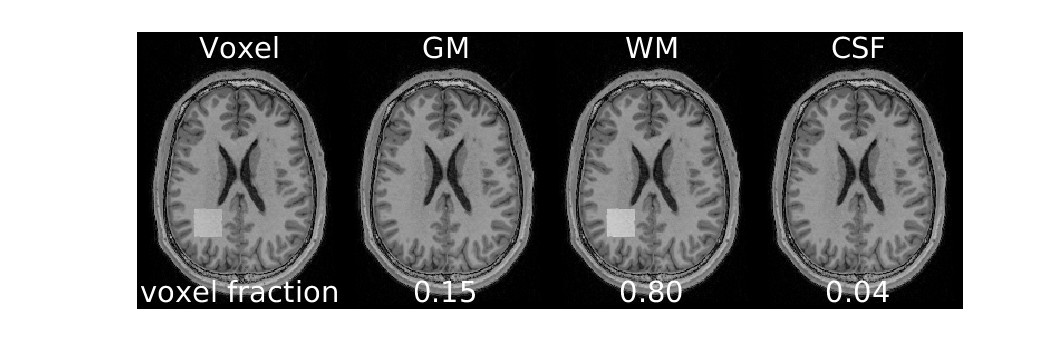

In [20]:
display(ipython_image(filename=f"{output_path}/Reports/reportFigures/sub-002/sub-002_seg_svs_space-scanner_mask.jpg"))

### Spectral modelling
- Osprey runs LCModel for spectral fitting

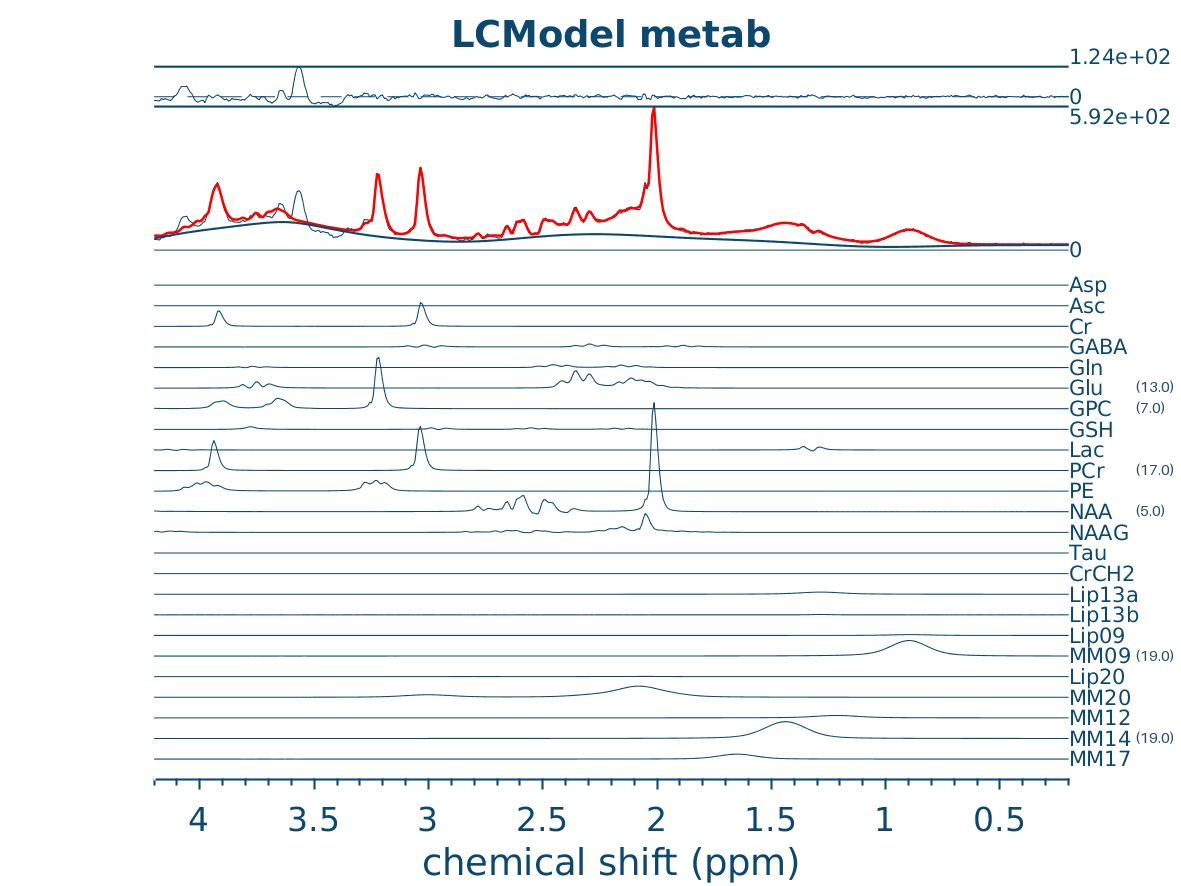

In [21]:
crlb_threshold = 20

# Make sure to only include the metabolites in the LCmodel plot.
metabolites = [
    'Asp', 'Asc', 'Cr', 'GABA', 'Gln', 'Glu', 'GPC', 'GSH', 'Lac',
    'PCr', 'PE', 'NAA', 'NAAG', 'Tau', 'CrCH2', 'Lip13a', 'Lip13b',
    'Lip09', 'MM09', 'Lip20', 'MM20', 'MM12', 'MM14', 'MM17'
]

# crlbs = pd.read_csv(f'{output_path}/QuantifyResults/A_CRLB_Voxel_1_Basis_1.tsv', delimiter='\t')[metabolites]
crlbs = pd.read_csv(f'{output_path}/QuantifyResults/A_CRLB_Voxel_1_Basis_1.tsv', delimiter='\t')[metabolites]
crlb_dict = crlbs.iloc[0, :].to_dict()

# Osprey fitting results image.
# img_path = f"{output_path}/Reports/reportFigures/sub-002/sub-002_metab_A_model.jpg"
img_path = f"{output_path}/Reports/reportFigures/sub-002/sub-002_metab_A_model.jpg"
img = Image.open(img_path)

# Draw CRLBs on top of the image.
draw = ImageDraw.Draw(img)
font = ImageFont.load_default(size=15)

x, y = 1135, 253
for met, crlb in crlb_dict.items():
    y += 20.67  # shift down for next line
    # Only show
    if crlb < crlb_threshold:
        draw.text((x, y), f"({crlb:.1f})", fill="#2e4b67", font=font)

display(img)

In [22]:
# HTML-formatted title so that it can be combined with an image.
title = widgets.HTML(
    f"""
    <div style='
        font:25px sans-serif;
        text-align:center;
        color:black;
        background-color:white;
        padding:10px;
        display:block;
        width:100%;
        box-sizing:border-box;
    '>
        Averaged spectra
    </div>
    """
)

img = widgets.Image.from_file(f"{output_path}/Reports/reportFigures/sub-002/sub-002_metab_A.jpg")

# Put the title above the image.
panel = widgets.VBox([title, img], layout=widgets.Layout(width="50%"))
display(panel)

### Metabolite concetrations
- Osprey calculates metabolite concentrations relative to different references

In [23]:
metabolites = ['Cr', 'GABA', 'Gln', 'Glu', 'GPC', 'GSH', 'Lac', 'PCr', 'PE', 'NAA', 'NAAG', 'Tau', 'CrCH2', 'tCr', 'tNAA', 'Glx']

def plot_metabolites(data, figsize=(20, 5), label='(raw values in arbitrary units)', ytick_step=0.2):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.bar(height=data.values[0], x=data.columns, zorder=2)
    ax.set_title(f'Metabolites\n{label}')
    
    ylims = ax.get_ylim()
    yticks = np.arange(ylims[0], ylims[1], ytick_step)
    ax.set_yticks(yticks)
    
    ax.grid(axis='y', zorder=1)

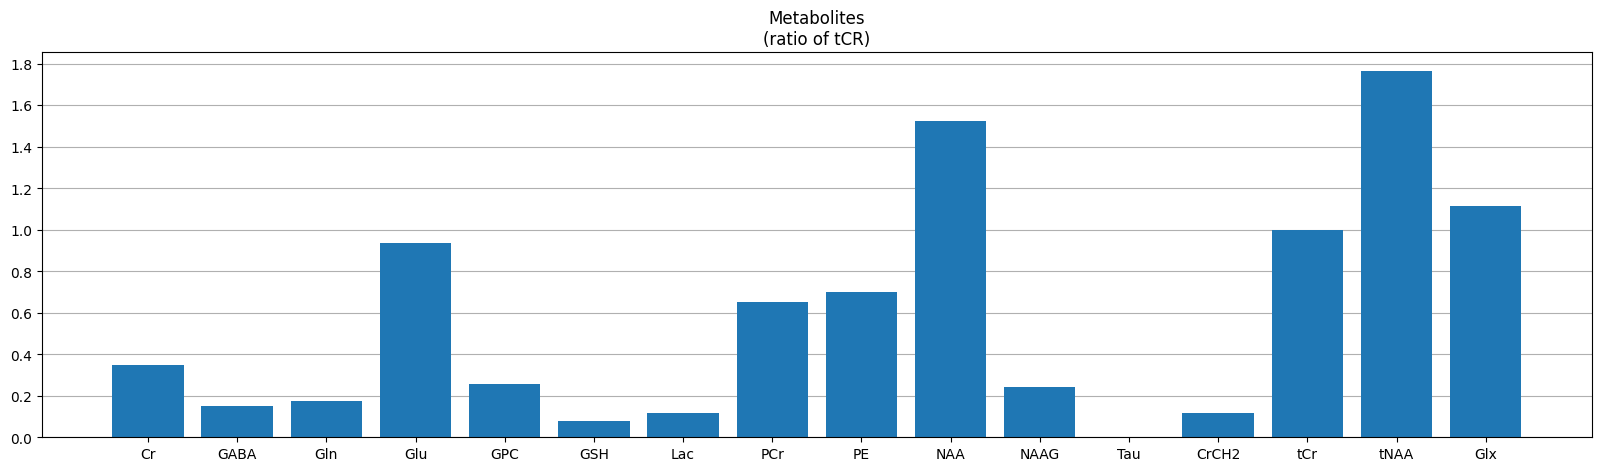

In [24]:
met_data = pd.read_csv(f'{output_path}/QuantifyResults/A_tCr_Voxel_1_Basis_1.tsv', delimiter='\t')
plot_metabolites(met_data[metabolites], label='(ratio of tCR)')

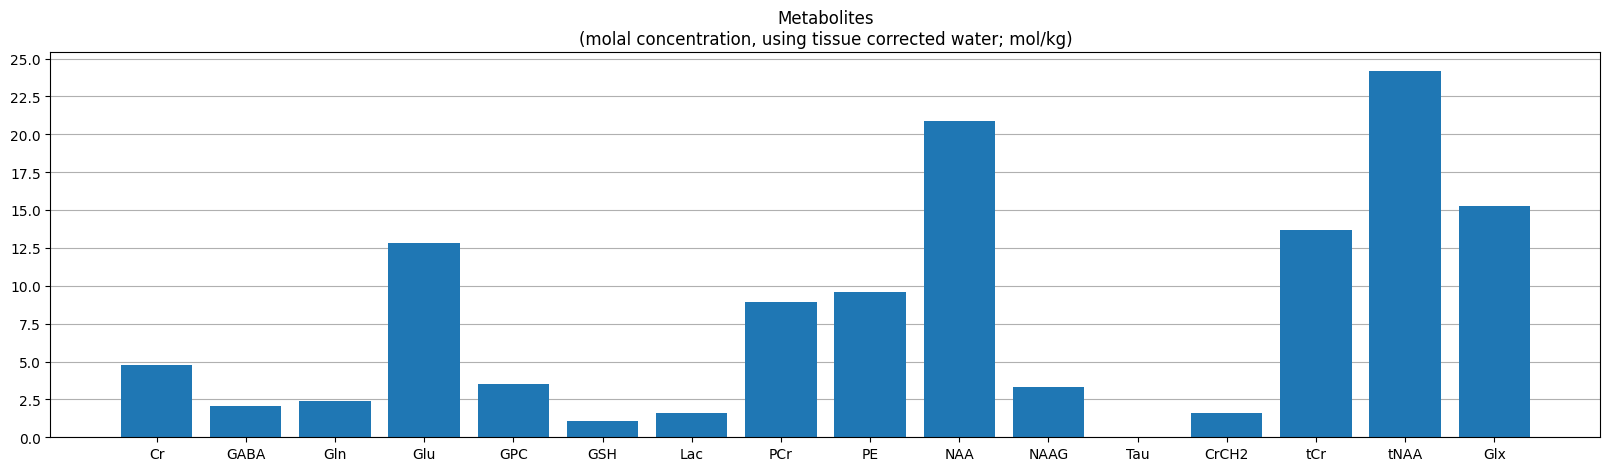

In [25]:
met_data = pd.read_csv(f'{output_path}/QuantifyResults/A_TissCorrWaterScaled_Voxel_1_Basis_1.tsv', delimiter='\t')
plot_metabolites(met_data[metabolites], label='(molal concentration, using tissue corrected water; mol/kg)', ytick_step=2.5)